In [1]:
import mlrose_hiive as mlrose
import pandas as pd
import numpy as np
import math
import time
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, average_precision_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import itertools
import matplotlib.pyplot as plt

In [2]:
random_state = 2020
max_attempts = 20
max_iters = 2000
N = 3
init_state_seeds = range(N)
metric = 'accuracy'
def scoring(gt, pred):
    return accuracy_score(gt, pred)

In [3]:
trainval_df = pd.read_csv('dataset2/processed_trainval_data.csv')
display(trainval_df.shape)
display(trainval_df.head())

(1178, 22)

,media_exposure,wife_religion,num_children_born,wife_working,wife_age,wife_education_1,wife_education_2,wife_education_3,wife_education_4,husband_education_1,...,husband_education_4,husband_occupation_1,husband_occupation_2,husband_occupation_3,husband_occupation_4,standard_of_living_index_1,standard_of_living_index_2,standard_of_living_index_3,standard_of_living_index_4,label
0,0,0,2,1,28,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,1,1,1,0,27,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2,0,1,2,1,28,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,0,1,3,1,24,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,0,0,4,1,35,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [4]:
test_df = pd.read_csv('dataset2/processed_test_data.csv')
display(test_df.shape)
display(test_df.head())

(295, 22)

,media_exposure,wife_religion,num_children_born,wife_working,wife_age,wife_education_1,wife_education_2,wife_education_3,wife_education_4,husband_education_1,...,husband_education_4,husband_occupation_1,husband_occupation_2,husband_occupation_3,husband_occupation_4,standard_of_living_index_1,standard_of_living_index_2,standard_of_living_index_3,standard_of_living_index_4,label
0,0,1,7,0,34,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,0,1,1,0,22,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,1,1,10,1,41,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0,1,6,0,47,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
4,0,1,3,1,40,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [5]:
features = list(set(trainval_df.columns) - set(['label']))
label = ['label']
trainval_X = trainval_df[features]
trainval_Y = trainval_df[label]
test_X = test_df[features]
test_Y = test_df[label]

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(trainval_X, trainval_Y)
for train_index, test_index in sss.split(trainval_X, trainval_Y):
    train_X, val_X = trainval_X.iloc[train_index], trainval_X.iloc[test_index]
    train_Y, val_Y = trainval_Y.iloc[train_index], trainval_Y.iloc[test_index]

In [7]:
scaler = MinMaxScaler()
train_X[features] = scaler.fit_transform(train_X)
val_X[features] = scaler.transform(val_X)
test_X[features] = scaler.transform(test_X)

### Gradient Descent

In [28]:
params_list = []
optimal_train_metric_list = []
optimal_val_metric_list = []
avg_fitness_evals_list = []
average_time_taken_list = []
for trial in ['default']:
    start_time = time.time()
    best_train_metrics = []
    best_val_metrics = []
    curves = []

    for idx, init_state_seed in enumerate(init_state_seeds):

        nn_model = mlrose.NeuralNetwork(hidden_nodes=[20, 8], activation='relu', \
                                         algorithm='gradient_descent', max_iters=max_iters, \
                                         bias=True, is_classifier=True, learning_rate=0.001, \
                                         early_stopping=True, max_attempts=max_attempts,
                                         random_state=init_state_seed, curve=True)

        nn_model.fit(train_X, train_Y)
        
        loss = nn_model.loss
        curve = nn_model.fitness_curve

        train_y_pred = nn_model.predict(train_X)
        train_metric = scoring(train_Y, train_y_pred)

        val_y_pred = nn_model.predict(val_X)
        val_metric = scoring(val_Y, val_y_pred)
        
        best_train_metrics.append(train_metric)
        best_val_metrics.append(val_metric)
        
        print(len(curve))
        curves.append(curve)
        

    end_time = time.time()
    total_time = round(end_time - start_time, 5)
    average_time_taken = round(total_time / N, 5)
    average_best_train_metrics = np.mean(best_train_metrics)
    average_best_val_metrics = np.mean(best_val_metrics)
    avg_fitness_evals = int(len(list(itertools.chain(*curves))) / N)
    
    params_list.append(trial)
    avg_fitness_evals_list.append(avg_fitness_evals)
    optimal_train_metric_list.append(average_best_train_metrics)
    optimal_val_metric_list.append(average_best_val_metrics)
    average_time_taken_list.append(average_time_taken)
    
    print(f'------- default, total_time = {total_time} -------')
    print(f'The average time taken for one run to reach the best state is {average_time_taken} seconds')
    print(f'The average train metric at the best state is {average_best_train_metrics}')
    print(f'The average val metric at the best state is {average_best_val_metrics}')
    print('\n')
    
sgd_dict = {'params': params_list,
           'train_metric': optimal_train_metric_list,
           'val_metric': optimal_val_metric_list,
           'fitness_evaluations': avg_fitness_evals_list,
           'average_time_taken': average_time_taken_list}

()
2000
()
2000
()
2000
------- default, total_time = 73.85945 -------
The average time taken for one run to reach the best state is 24.61982 seconds
The average train metric at the best state is 0.8273177636234962
The average val metric at the best state is 0.6850282485875706




In [9]:
sgd_dict

{'params': ['default'],
 'train_metric': [0.7965322009907997],
 'val_metric': [0.653954802259887],
 'fitness_evaluations': [2000],
 'average_time_taken': [24.5598]}

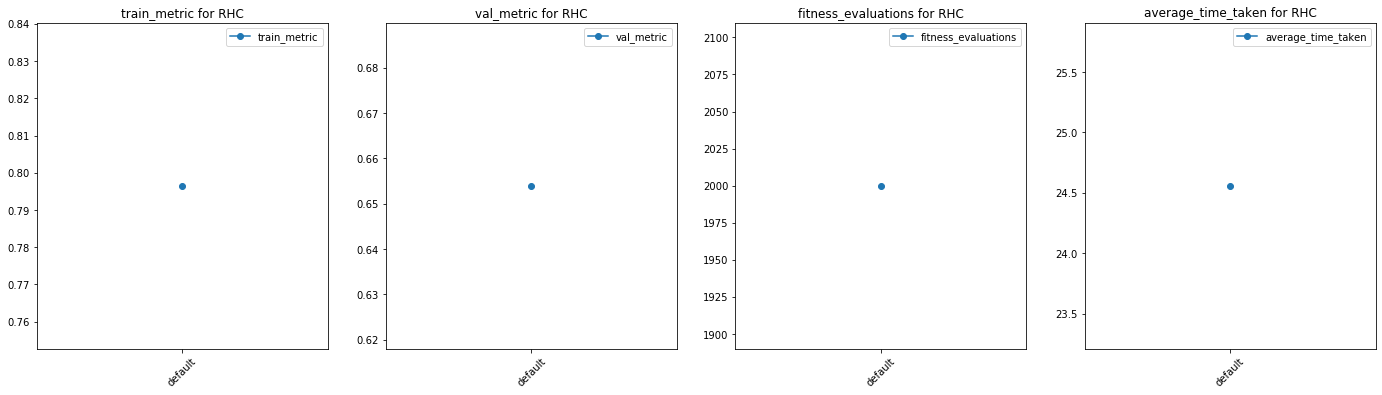

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
temp_dict = sgd_dict.copy()
temp_dict.pop('params')
for ax, (key, val) in zip(axes.ravel(), temp_dict.items()):
    if key == 'params':
        continue
    ax.set_title(f"{key} for RHC")
    ax.plot(sgd_dict['params'], val, label=key, marker = 'o')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc=0)
plt.show()

### Random Hill Climb

In [11]:
params_list = []
optimal_train_metric_list = []
optimal_val_metric_list = []
avg_fitness_evals_list = []
average_time_taken_list = []
for restarts in [5, 10, 15]:
    start_time = time.time()
    best_train_metrics = []
    best_val_metrics = []
    curves = []
    for idx, init_state_seed in enumerate(init_state_seeds):

        nn_model = mlrose.NeuralNetwork(hidden_nodes=[20, 8], activation='relu', \
                                         algorithm='random_hill_climb', max_iters=max_iters, \
                                         bias=True, is_classifier=True, learning_rate=0.001, \
                                         early_stopping=True, max_attempts=max_attempts,
                                         random_state=init_state_seed+idx, curve=True)

        nn_model.fit(train_X, train_Y)

        loss = nn_model.loss
        curve = nn_model.fitness_curve

        train_y_pred = nn_model.predict(train_X)
        train_metric = scoring(train_Y, train_y_pred)

        val_y_pred = nn_model.predict(val_X)
        val_metric = scoring(val_Y, val_y_pred)
        
        best_train_metrics.append(train_metric)
        best_val_metrics.append(val_metric)
        curves.append(curve)

    end_time = time.time()
    total_time = round(end_time - start_time, 5)
    average_time_taken = round(total_time / N, 5)
    average_best_train_metrics = np.mean(best_train_metrics)
    average_best_val_metrics = np.mean(best_val_metrics)
    avg_fitness_evals = int(len(list(itertools.chain(*curves))) / N)
    
    params_list.append(f'restarts={restarts}')
    avg_fitness_evals_list.append(avg_fitness_evals)
    optimal_train_metric_list.append(average_best_train_metrics)
    optimal_val_metric_list.append(average_best_val_metrics)
    average_time_taken_list.append(average_time_taken)
    
    print(f'------- restart = {restarts}, total_time = {total_time} -------')
    print(f'The average time taken for one run to reach the best state is {average_time_taken} seconds')
    print(f'The average train metric at the best state is {average_best_train_metrics}')
    print(f'The average val metric at the best state is {average_best_val_metrics}')
    print('\n')
    
rhc_dict = {'params': params_list,
            'train_metric': optimal_train_metric_list,
            'val_metric': optimal_val_metric_list,
            'fitness_evaluations': avg_fitness_evals_list,
            'average_time_taken': average_time_taken_list}

------- restart = 5, total_time = 40.96771 -------
The average time taken for one run to reach the best state is 13.6559 seconds
The average train metric at the best state is 0.45470629865534323
The average val metric at the best state is 0.4632768361581921


------- restart = 10, total_time = 40.7814 -------
The average time taken for one run to reach the best state is 13.5938 seconds
The average train metric at the best state is 0.4483368719037509
The average val metric at the best state is 0.46610169491525427


------- restart = 15, total_time = 42.09636 -------
The average time taken for one run to reach the best state is 14.03212 seconds
The average train metric at the best state is 0.4483368719037509
The average val metric at the best state is 0.46610169491525427




In [12]:
rhc_dict

{'params': ['restarts=5', 'restarts=10', 'restarts=15'],
 'train_metric': [0.45470629865534323, 0.4483368719037509, 0.4483368719037509],
 'val_metric': [0.4632768361581921, 0.46610169491525427, 0.46610169491525427],
 'fitness_evaluations': [2000, 2000, 2000],
 'average_time_taken': [13.6559, 13.5938, 14.03212]}

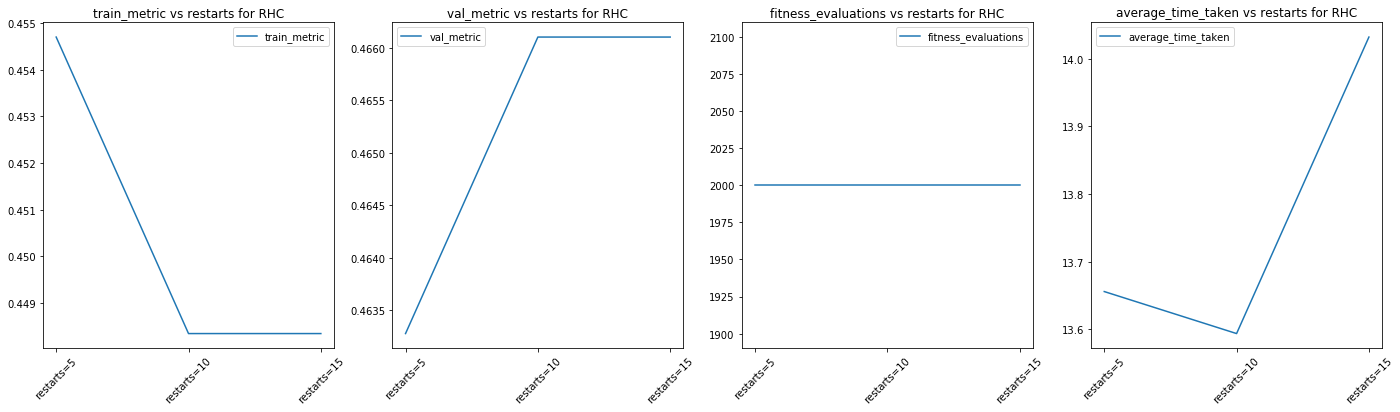

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
temp_dict = rhc_dict.copy()
temp_dict.pop('params')
for ax, (key, val) in zip(axes.ravel(), temp_dict.items()):
    if key == 'params':
        continue
    ax.set_title(f"{key} vs restarts for RHC")
    ax.plot(rhc_dict['params'], val, label=key)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc=0)
plt.show()

### Simulated Annealing

In [14]:
params_list = []
optimal_train_metric_list = []
optimal_val_metric_list = []
avg_fitness_evals_list = []
average_time_taken_list = []
for exp_const in [0.001, 0.005, 0.01]:
    for init_temp in [0.3, 0.6]:
        start_time = time.time()
        best_train_metrics = []
        best_val_metrics = []
        curves = []
        for idx, init_state_seed in enumerate(init_state_seeds):
            schedule = mlrose.ExpDecay(init_temp = init_temp, exp_const = exp_const)
            nn_model = mlrose.NeuralNetwork(hidden_nodes=[20, 8], activation='relu', \
                                             algorithm='simulated_annealing', max_iters=max_iters, \
                                             bias=True, is_classifier=True, learning_rate=0.001, \
                                             early_stopping=True, schedule=schedule,
                                             max_attempts=max_attempts, random_state=init_state_seed+idx, curve=True)

            nn_model.fit(train_X, train_Y)

            loss = nn_model.loss
            curve = nn_model.fitness_curve

            train_y_pred = nn_model.predict(train_X)
            train_metric = scoring(train_Y, train_y_pred)

            val_y_pred = nn_model.predict(val_X)
            val_metric = scoring(val_Y, val_y_pred)

            best_train_metrics.append(train_metric)
            best_val_metrics.append(val_metric)
            curves.append(curve)

        end_time = time.time()
        total_time = round(end_time - start_time, 5)
        average_time_taken = round(total_time / N, 5)
        average_best_train_metrics = np.mean(best_train_metrics)
        average_best_val_metrics = np.mean(best_val_metrics)
        avg_fitness_evals = int(len(list(itertools.chain(*curves))) / N)

        params_list.append(f'exp_const={exp_const}_init_temp={init_temp}')
        avg_fitness_evals_list.append(avg_fitness_evals)
        optimal_train_metric_list.append(average_best_train_metrics)
        optimal_val_metric_list.append(average_best_val_metrics)
        average_time_taken_list.append(average_time_taken)

        print(f'------- exp_const = {exp_const}, init_temp = {init_temp}, total_time = {total_time} -------')
        print(f'The average time taken for one run to reach the best state is {average_time_taken} seconds')
        print(f'The average train metric at the best state is {average_best_train_metrics}')
        print(f'The average val metric at the best state is {average_best_val_metrics}')
        print('\n')
    
sa_dict = {'params': params_list,
          'train_metric': optimal_train_metric_list,
          'val_metric': optimal_val_metric_list,
          'fitness_evaluations': avg_fitness_evals_list,
          'average_time_taken': average_time_taken_list}

------- exp_const = 0.001, init_temp = 0.3, total_time = 55.23793 -------
The average time taken for one run to reach the best state is 18.41264 seconds
The average train metric at the best state is 0.4451521585279547
The average val metric at the best state is 0.46045197740113


------- exp_const = 0.001, init_temp = 0.6, total_time = 57.48377 -------
The average time taken for one run to reach the best state is 19.16126 seconds
The average train metric at the best state is 0.47416843595187547
The average val metric at the best state is 0.4759887005649717


------- exp_const = 0.005, init_temp = 0.3, total_time = 54.42224 -------
The average time taken for one run to reach the best state is 18.14075 seconds
The average train metric at the best state is 0.47416843595187547
The average val metric at the best state is 0.4759887005649717


------- exp_const = 0.005, init_temp = 0.6, total_time = 54.45568 -------
The average time taken for one run to reach the best state is 18.15189 second

In [15]:
sa_dict

{'params': ['exp_const=0.001_init_temp=0.3',
  'exp_const=0.001_init_temp=0.6',
  'exp_const=0.005_init_temp=0.3',
  'exp_const=0.005_init_temp=0.6',
  'exp_const=0.01_init_temp=0.3',
  'exp_const=0.01_init_temp=0.6'],
 'train_metric': [0.4451521585279547,
  0.47416843595187547,
  0.47416843595187547,
  0.47416843595187547,
  0.47416843595187547,
  0.4295824486907289],
 'val_metric': [0.46045197740113,
  0.4759887005649717,
  0.4759887005649717,
  0.4759887005649717,
  0.4759887005649717,
  0.43502824858757067],
 'fitness_evaluations': [2000, 2000, 2000, 2000, 2000, 2000],
 'average_time_taken': [18.41264,
  19.16126,
  18.14075,
  18.15189,
  17.78199,
  18.19196]}

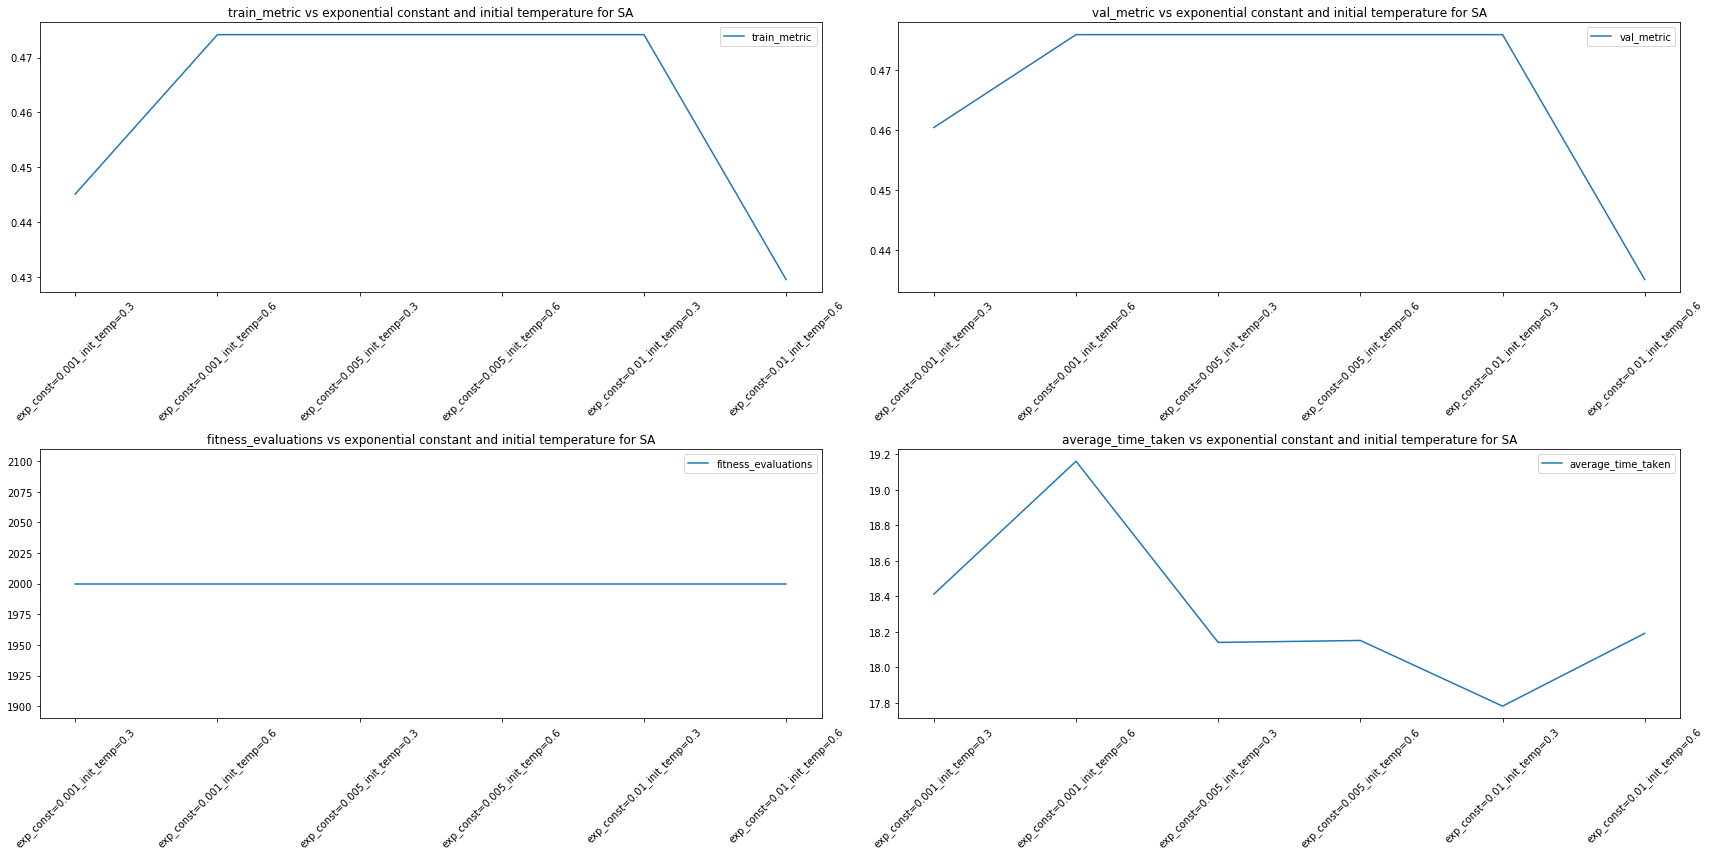

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12))
temp_dict = sa_dict.copy()
temp_dict.pop('params')
for ax, (key, val) in zip(axes.ravel(), temp_dict.items()):
    if key == 'params':
        continue
    ax.set_title(f"{key} vs exponential constant and initial temperature for SA")
    ax.plot(sa_dict['params'], val, label=key)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc=0)
    
fig.tight_layout()
plt.show()

### Genetic Algorithm

In [17]:
params_list = []
optimal_train_metric_list = []
optimal_val_metric_list = []
avg_fitness_evals_list = []
average_time_taken_list = []
for pop_size in [10, 30]:
    for mutation_prob in [0.3, 0.6]:
        start_time = time.time()
        best_train_metrics = []
        best_val_metrics = []
        curves = []
        for idx, init_state_seed in enumerate(init_state_seeds):
            schedule = mlrose.ExpDecay(init_temp = init_temp, exp_const = exp_const)
            nn_model = mlrose.NeuralNetwork(hidden_nodes=[20, 8], activation='relu', \
                                             algorithm='genetic_alg', max_iters=max_iters, \
                                             bias=True, is_classifier=True, learning_rate=0.001, \
                                             early_stopping=True, schedule=schedule,
                                             pop_size=pop_size, mutation_prob=mutation_prob, \
                                             max_attempts=max_attempts, random_state=init_state_seed+idx, curve=True)

            nn_model.fit(train_X, train_Y)

            loss = nn_model.loss
            curve = nn_model.fitness_curve

            train_y_pred = nn_model.predict(train_X)
            train_metric = scoring(train_Y, train_y_pred)

            val_y_pred = nn_model.predict(val_X)
            val_metric = scoring(val_Y, val_y_pred)

            best_train_metrics.append(train_metric)
            best_val_metrics.append(val_metric)
            curves.append(curve)

        end_time = time.time()
        total_time = round(end_time - start_time, 5)
        average_time_taken = round(total_time / N, 5)
        average_best_train_metrics = np.mean(best_train_metrics)
        average_best_val_metrics = np.mean(best_val_metrics)
        avg_fitness_evals = int(len(list(itertools.chain(*curves))) / N) * pop_size

        params_list.append(f'pop_size={pop_size}_mutation_prob={mutation_prob}')
        avg_fitness_evals_list.append(avg_fitness_evals)
        optimal_train_metric_list.append(average_best_train_metrics)
        optimal_val_metric_list.append(average_best_val_metrics)
        average_time_taken_list.append(average_time_taken)

        print(f'----- pop_size = {pop_size}, mutation_prob = {mutation_prob}, total_time = {total_time} ------')
        print(f'The average time taken for one run to reach the best state is {average_time_taken} seconds')
        print(f'The average train metric at the best state is {average_best_train_metrics}')
        print(f'The average val metric at the best state is {average_best_val_metrics}')
        print('\n')
    
ga_dict = {'params': params_list,
          'train_metric': optimal_train_metric_list,
          'val_metric': optimal_val_metric_list,
          'fitness_evaluations': avg_fitness_evals_list,
          'average_time_taken': average_time_taken_list}

----- pop_size = 10, mutation_prob = 0.3, total_time = 11.01889 ------
The average time taken for one run to reach the best state is 3.67296 seconds
The average train metric at the best state is 0.4982307147912244
The average val metric at the best state is 0.4717514124293785


----- pop_size = 10, mutation_prob = 0.6, total_time = 11.48146 ------
The average time taken for one run to reach the best state is 3.82715 seconds
The average train metric at the best state is 0.49610757254069354
The average val metric at the best state is 0.5014124293785311


----- pop_size = 30, mutation_prob = 0.3, total_time = 20.09275 ------
The average time taken for one run to reach the best state is 6.69758 seconds
The average train metric at the best state is 0.4911535739561217
The average val metric at the best state is 0.4717514124293786


----- pop_size = 30, mutation_prob = 0.6, total_time = 16.29982 ------
The average time taken for one run to reach the best state is 5.43327 seconds
The average t

In [18]:
ga_dict

{'params': ['pop_size=10_mutation_prob=0.3',
  'pop_size=10_mutation_prob=0.6',
  'pop_size=30_mutation_prob=0.3',
  'pop_size=30_mutation_prob=0.6'],
 'train_metric': [0.4982307147912244,
  0.49610757254069354,
  0.4911535739561217,
  0.5010615711252654],
 'val_metric': [0.4717514124293785,
  0.5014124293785311,
  0.4717514124293786,
  0.5028248587570622],
 'fitness_evaluations': [540, 460, 990, 690],
 'average_time_taken': [3.67296, 3.82715, 6.69758, 5.43327]}

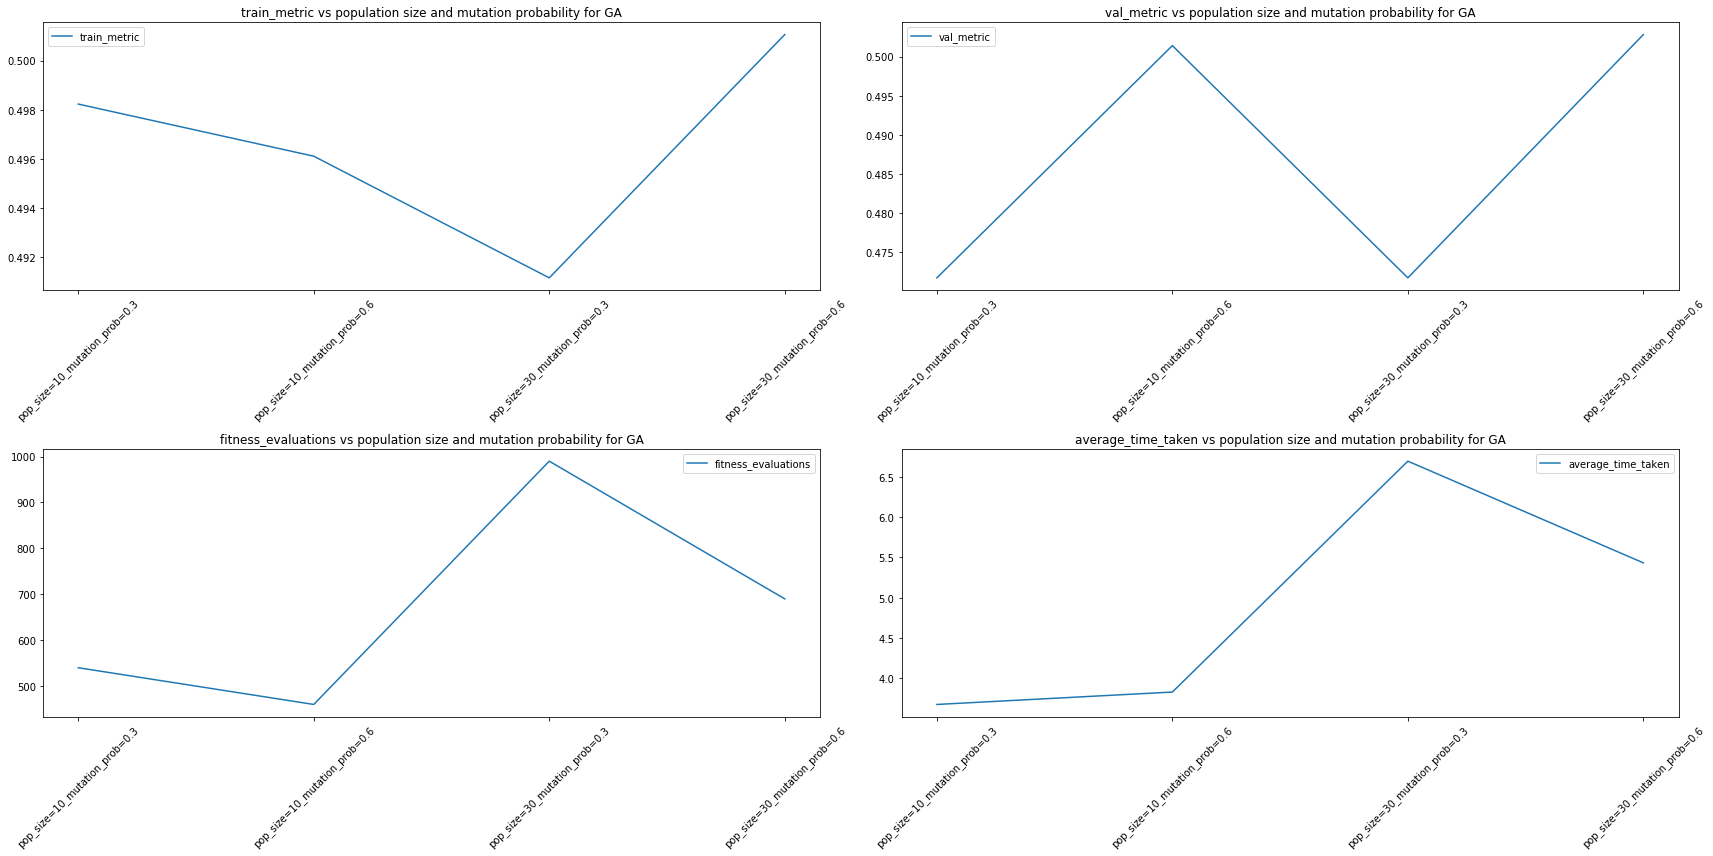

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12))
temp_dict = ga_dict.copy()
temp_dict.pop('params')
for ax, (key, val) in zip(axes.ravel(), temp_dict.items()):
    if key == 'params':
        continue
    ax.set_title(f"{key} vs population size and mutation probability for GA")
    ax.plot(ga_dict['params'], val, label=key)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc=0)
fig.tight_layout()
plt.show()

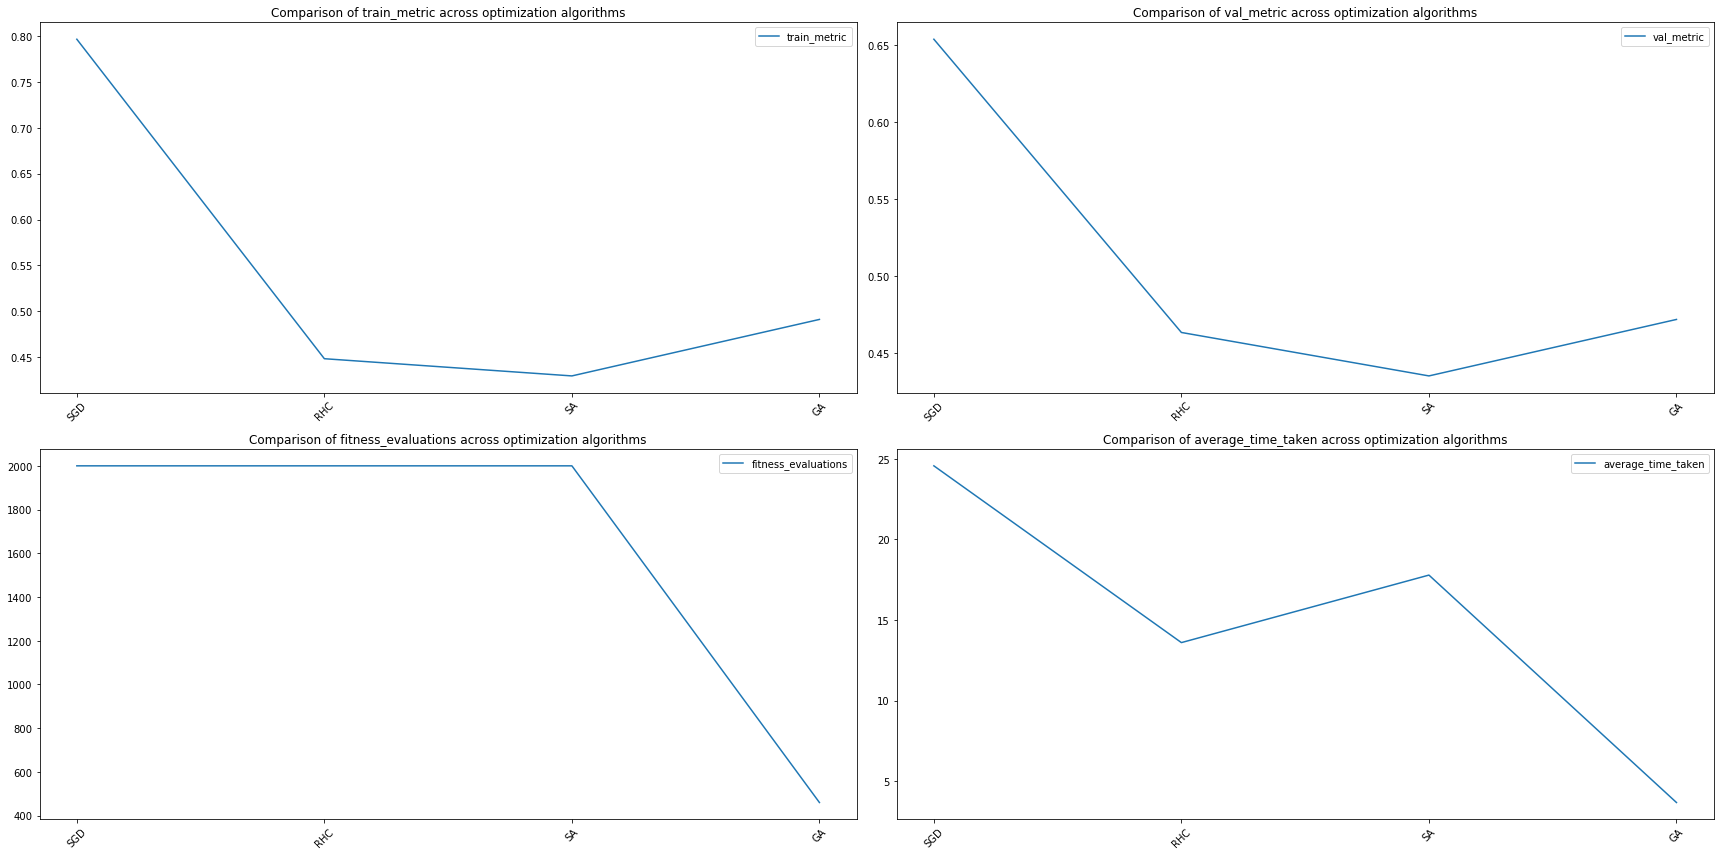

In [26]:
algorithms = ['SGD', 'RHC', 'SA', 'GA']
algo_dict_list = [sgd_dict, rhc_dict, sa_dict, ga_dict]
fig, axes = plt.subplots(2, 2, figsize=(24, 12))
for ax, key in zip(axes.ravel(), ['train_metric', 'val_metric', 'fitness_evaluations', 'average_time_taken']):

    ax.set_title(f"Comparison of {key} across optimization algorithms")
    if key == 'best_fitness':
        optimal_metrics = [np.max(np.array(algo_dict[key])) for algo_dict in algo_dict_list]
    else:
        optimal_metrics = [np.min(np.array(algo_dict[key])) for algo_dict in algo_dict_list]
    ax.plot(algorithms, optimal_metrics, label=key)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc=0)

fig.tight_layout()
plt.show()